In [52]:
import numpy as np

class BasicNNModule:
    def __init__(self):
        self.lr = 0.001

class SingleLinear(BasicNNModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weights = np.ones((out_features, in_features)) * 0.5
        self.bias = np.zeros(out_features)

    def forward(self, x):
        return np.matmul(x, self.weights.T) + self.bias
    
    def backward(self, delta_next_layer, w_next_layer, b_next_layer, a_cur_layer, y_last_layer):
        # print(d2y.shape, y2i.shape, y_last_layer.shape)
        # delta = d2y * y2i
        delta = (np.matmul(delta_next_layer.T, w_next_layer) * a_cur_layer).T
        # print(delta)
        # L2 regularization
        self.weights += self.lr * (np.matmul(delta, y_last_layer) - 0.01 * self.weights)
        # self.weights += self.lr * np.matmul(delta, y_last_layer)
        self.bias += self.lr * delta.T[0]
        return delta, self.weights, self.bias
    
    def softmax_backward(self, y, label, y_last_layer):
        delta = (y - label).T
        # print('before update:', self.weights, self.bias)
        # print(delta.shape, y_last_layer.shape, self.bias.shape)

        # L2 regularization
        self.weights += self.lr * (np.matmul(delta, y_last_layer) - 0.01 * self.weights)
        # self.weights += self.lr * np.matmul(delta, y_last_layer)

        self.bias += self.lr * delta.T[0]
        # print('after update:', self.weights, self.bias)
        return delta, self.weights, self.bias

class relu:
    def forward(self, x):
        return np.maximum(x, 0)
    
    def backward(self, x):
        return np.where(x > 0, 1, 0)
    
class Softmax:
    def forward(self, x):
        # 減去最大值以防止 overflow
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    


In [53]:
import numpy as np

with open('Iris.csv') as f:
    data = f.readlines()[1:]

data = [line.strip().split(',')[1:] for line in data]
data = np.array(data)
labels = []

classes = np.unique(data[:, 4])

for d in data:
    for cls in classes:
        if d[4] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

inputs = data[:, :4].astype(np.float32)

# inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

labels = np.array(labels)

# 打亂數據
idx = np.random.permutation(len(inputs))
inputs = inputs[idx]
labels = labels[idx]


linear_1 = SingleLinear(4, 5)
relu_1 = relu()
linear_2 = SingleLinear(5, 5)
relu_2 = relu()
linear_3 = SingleLinear(5, 3)
softmax_3 = Softmax()

for _ in range(5):

    for input, label in zip(inputs, labels):
        input = input.reshape(1, -1)
        # print(input, label)
        i_1 = linear_1.forward(input)
        y_1 = relu_1.forward(i_1)
        i_2 = linear_2.forward(y_1)
        y_2 = relu_2.forward(i_2)
        i_3 = linear_3.forward(y_2)
        print("i_3", i_3)
        y_3 = softmax_3.forward(i_3)
        print("y_3", y_3)
        print("label", label)
        delta_3, w_3, b_3 = linear_3.softmax_backward(y_3, label, y_2)
        delta_2, w_2, b_2 = linear_2.backward(delta_3, w_3, b_3, relu_2.backward(i_2), y_1)
        delta_1, w_1, b_1 = linear_1.backward(delta_2, w_2, b_2, relu_1.backward(i_1), input)
        # print('delta_3:\n', delta_3)
        # print('w_3:\n', w_3)
        # print('b_3:\n', b_3)
        
        # print('delta_2:\n', delta_2)
        # print('w_2:\n', w_2)
        # print('b_2:\n', b_2)
        # break
        # delta_1 = linear_1.backward(- ())
    

i_3 [[54.3750003 54.3750003 54.3750003]]
y_3 [[0.33333333 0.33333333 0.33333333]]
label [0. 0. 1.]
i_3 [[41.5568772  41.5568772  39.77398712]]
y_3 [[0.46122239 0.46122239 0.07755522]]
label [0. 1. 0.]
i_3 [[62.47016478 60.48086146 59.06665168]]
y_3 [[0.85466658 0.11691043 0.02842299]]
label [0. 0. 1.]
i_3 [[54.77762723 51.26860936 47.37343496]]
y_3 [[9.70369771e-01 2.90395688e-02 5.90659799e-04]]
label [0. 0. 1.]
i_3 [[52.17019587 47.13785983 41.58343532]]
y_3 [[9.93493806e-01 6.48110998e-03 2.50838085e-05]]
label [0. 1. 0.]
i_3 [[34.14011414 28.73140791 26.32500918]]
y_3 [[9.95142687e-01 4.45568098e-03 4.01632084e-04]]
label [1. 0. 0.]
i_3 [[61.00026101 51.35021858 47.04598111]]
y_3 [[9.99934711e-01 6.44186271e-05 8.70371945e-07]]
label [0. 0. 1.]
i_3 [[54.61094859 44.32909123 38.66216061]]
y_3 [[9.99965634e-01 3.42476803e-05 1.18444382e-07]]
label [0. 1. 0.]
i_3 [[67.58409568 51.19769111 46.41658517]]
y_3 [[9.99999923e-01 7.64671469e-08 6.41308445e-10]]
label [0. 0. 1.]
i_3 [[64.1495

C:\Users\eddy2\AppData\Local\Temp\ipykernel_24120\1121332656.py:14: RuntimeWarning: overflow encountered in matmul
  return np.matmul(x, self.weights.T) + self.bias
C:\Users\eddy2\AppData\Local\Temp\ipykernel_24120\1121332656.py:50: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=1, keepdims=True)


In [135]:
np.matmul(delta_3.T, w_3)

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [171]:
class Softmax:
    def forward(self, x):
        # 減去最大值以防止 overflow
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
Softmax().forward(np.array([[1, 5, 2]]))

array([[0.01714783, 0.93623955, 0.04661262]])

# =======================================

In [ ]:
def init_params():
    W1 = np.ones((4, 10))
    b1 = np.zeros((1, 10))
    W2 = np.ones((10, 3))
    b2 = np.zeros((1, 3))
    return W1, b1, W2, b2

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return x > 0

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):

    # X shape: (bs, n_features)
    I1 = np.matmul(X, W1) + b1  
    Y1 = relu(I1)

    I2 = np.matmul(Y1, W2) + b2
    Y2 = softmax(I2)
    return I1, Y1, I2, Y2

def backward_prop(I1, Y1, Y2, W2, X, Y):

    # 設定標準化因子 (batch size的倒數) 將梯度標準化，避免 batch size 過大造成梯度累積過大
    m = X.shape[0]
    norm_factor = 1 / m
    
    delta_2 = Y2 - Y  # (bs, 3)

    # Y1.T shape -> (n_layer1, bs)
    # delta_2 shape -> (bs, n_layer2)

    dW2 = norm_factor * np.matmul(Y1.T, delta_2)  
    db2 = norm_factor * np.sum(delta_2, axis=0, keepdims=True)

    # dW2 shape -> (n_layer1, n_layer2)
    # db2 shape -> (1, n_layer2)

    # ========================================

    # delta_2 shape -> (bs, n_layer2)
    # W2.T shape -> (n_layer2, n_layer1)
    # d_relu(I1) shape -> (bs, n_layer1)

    delta_1 = np.matmul(delta_2, W2.T) * d_relu(I1)  
 
    # X.T shape -> (n_features, bs)
    # delta_1 shape -> (bs, n_layer1)
    
    dW1 = norm_factor * np.matmul(X.T, delta_1)  
    db1 = norm_factor * np.sum(delta_1, axis=0, keepdims=True)

    # dW1 shape -> (n_features, n_layer1)
    # db1 shape -> (1, n_layer1)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    Y = np.argmax(Y, axis=1)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X_all, Y_all, X_val, Y_val, alpha, iterations, bs):
    # X_all -> (n_samples, n_features)
    # Y_all -> (n_samples, n_classes) one-hot 
    
    W1, b1, W2, b2 = init_params()
    
    # 將全部的資料打包成 batch，每個 batch 的大小為 bs
    X_batch = X_all.reshape(-1, bs, X_all.shape[1])
    Y_batch = Y_all.reshape(-1, bs, Y_all.shape[1])
    
    for i in range(iterations):
        loss = 0
        for X, Y in zip(X_batch, Y_batch):
          
            # print('Y shape:', Y.shape, 'Y_all shape:', Y_all.shape)
            I1, Y1, I2, Y2 = forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = backward_prop(I1, Y1, Y2, W2, X, Y)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
            loss += -np.sum(Y * np.log(Y2))

        if i % 1 == 0:
            print("Iteration: ", i)
            print("Loss: ", loss)
            _, _, _, pred = forward_prop(W1, b1, W2, b2, X_val)
            predictions = get_predictions(pred)
            print('Acc:', get_accuracy(predictions, Y_val))
            # print(predictions, Y)
        break

    return W1, b1, W2, b2

In [ ]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('Iris.csv') as f:
    data = f.readlines()[1:]

data = [line.strip().split(',')[1:] for line in data]
data = np.array(data)
labels = []

classes = np.unique(data[:, 4])

for d in data:
    for cls in classes:
        if d[4] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

inputs = data[:, :4].astype(np.float32)

# inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

labels = np.array(labels)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
# Y_train = np.argmax(labels, axis=0)

Y_data = labels[idx]

train_size = int(len(X_data) * 0.8)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)

batch_size = 120
lr = 0.05

W1, b1, W2, b2 = gradient_descent(X_train, Y_train, X_val, Y_val, lr, 30, batch_size)
# W1, b1, W2, b2

(120, 4)
d_relu(I1): (120, 10)
Iteration:  0
Loss:  131.83347464017316
Acc: 0.36666666666666664


In [24]:
x = np.random.randn(4, 3)
y = np.random.randn(3, 4)

print(np.matmul(y.T, x.T))
print(np.matmul(x, y).T)


[[-2.42146685 -1.49794256 -0.89849127 -0.66365005]
 [-0.51160228  0.93826069 -0.27637929 -0.5548736 ]
 [-0.35771471 -1.06233953 -0.41493013 -0.36709497]
 [ 3.28614577  4.57316731  1.2664861   0.41866526]]
[[-2.42146685 -1.49794256 -0.89849127 -0.66365005]
 [-0.51160228  0.93826069 -0.27637929 -0.5548736 ]
 [-0.35771471 -1.06233953 -0.41493013 -0.36709497]
 [ 3.28614577  4.57316731  1.2664861   0.41866526]]


## =================== 改良 =====================


In [127]:
import numpy as np
import matplotlib.pyplot as plt

def forward(params, X):
    forward_val = {'I': [], 'Y': []}
    # X shape: (bs, n_features)

    for idx, (w, b, act_func) in enumerate(zip(params['w'], params['b'], params['act_func'])):
        # print('forward idx:', idx, 'X shape:', X.shape, 'w', w[0])
        if idx == 0:
            I = np.matmul(X, w) + b
        else:
            I = np.matmul(Y, w) + b
        Y = act_func.f(I)
        # print('idx:', idx, 'I shape:', I.shape, 'Y shape:', Y.shape)
        forward_val['I'].append(I)
        forward_val['Y'].append(Y)

    return forward_val

def backward(params: dict, forward_val: dict, input_feat, label) -> dict:

    params_delta = {'W': [], 'b': []}

    # 設定標準化因子 (batch size的倒數) 將梯度標準化，避免 batch size 過大造成梯度累積過大
    m = input_feat.shape[0]
    norm_factor = 1 / m
    n_layer = len(params['w'])

    for idx, (Y, I, W, act_func) in enumerate(zip(forward_val['Y'][::-1], forward_val['I'][::-1], params['w'][::-1], params['act_func'][::-1])):
        # 由 output layer 開始計算 delta params，所以將 forward_val & params 反轉

        # 當目前為 output layer 時
        # delta 為 dL/dY * dY/dI -> Cross Entropy Loss 與 Softmax 的導函數相乘
        # 可化簡為 Y - label
        
        if idx == 0:
            delta = Y - label
        else:
            # print('idx', idx, 'delta shape:', delta.shape, 'W shape:', W.shape)
            delta = np.matmul(delta, next_layer_w.T) * act_func.b(I)
       

        # 當目前為 input layer 時，dW 的左矩陣為 input_feat.T
        if idx == n_layer - 1:
            dW = norm_factor * np.matmul(input_feat.T, delta)
        else:
            dW = norm_factor * np.matmul(forward_val['Y'][::-1][idx+1].T, delta)
            
        db = norm_factor * np.sum(delta, axis=0, keepdims=True)

        
        params_delta['W'].append(dW)
        params_delta['b'].append(db)
        next_layer_w = W

    return params_delta

def update_params(params: dict, params_delta: dict, lr) -> dict:

    for idx, (W, b, dW, db) in enumerate(zip(params['w'], params['b'], params_delta['W'][::-1], params_delta['b'][::-1])):
        # 從 input layer 開始更新 params，所以將 dW, db 反轉
        params['w'][idx] = W - lr * dW
        params['b'][idx] = b - lr * db

    return params

def get_pred(A2):
    return np.argmax(A2, axis=1)

def calculate_acc(predictions, Y):
    Y = np.argmax(Y, axis=1)
    return np.sum(predictions == Y) / Y.size

def train(params, X_all, Y_all, X_val, Y_val, alpha, Epoch, bs):
    # X_all -> (n_samples, n_features)
    # Y_all -> (n_samples, n_classes) one-hot 
    
    # 將全部的資料打包成 batch，每個 batch 的大小為 bs
    X_batch = X_all.reshape(-1, bs, X_all.shape[1])
    Y_batch = Y_all.reshape(-1, bs, Y_all.shape[1])
    
    train_loss_arr = []
    val_loss_arr = []
    
    val_acc_arr = []

    for i in range(Epoch):
        loss = 0
        for X, Y in zip(X_batch, Y_batch):
          
            forward_val = forward(params, X)
            params_delta = backward(params, forward_val, X, Y)
            params = update_params(params, params_delta, alpha)
            loss += -np.sum(Y * np.log(forward_val['Y'][-1]))

        # print("Epoch: ", i)
        # print('Loss:', round(loss, 2))
        pred = forward_prop(params, X_val)
        predictions = get_pred(pred['Y'][-1])
        # print('Val Acc:', round(get_accuracy(predictions, Y_val), 2))
        
        train_loss_arr.append(loss.mean())
        val_loss_arr.append(-np.sum(Y_val * np.log(pred['Y'][-1])))
        val_acc_arr.append(calculate_acc(predictions, Y_val))

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_loss_arr)
    plt.plot(val_loss_arr)
    plt.legend(['Train Loss', 'Val Loss'])

    plt.subplot(1, 2, 2)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Val Acc')
    plt.plot(val_acc_arr)
    plt.show()
    return params


class ReLU:
    def f(x):
        return np.maximum(x, 0)
    def b(x):
        return x > 0
    
class Softmax:
    def f(x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)



## ========== Iris ==========

(120, 4)


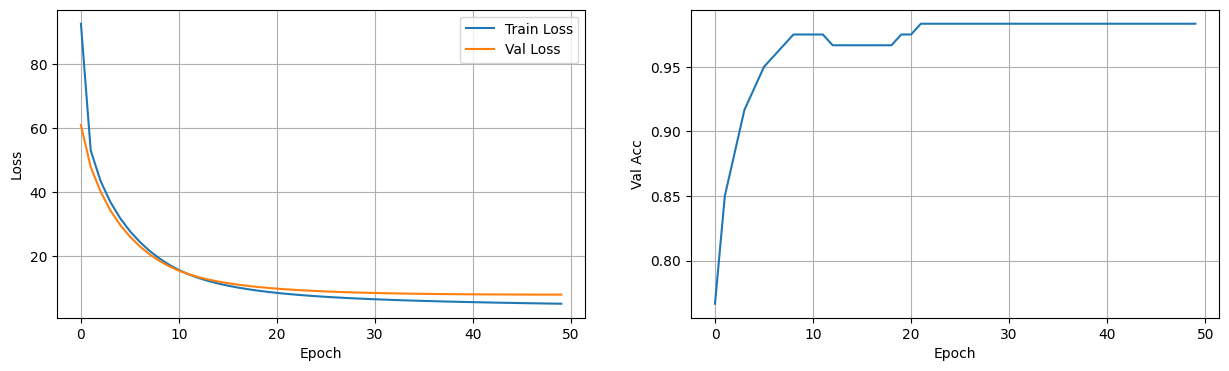

In [128]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('Iris.csv') as f:
    data = f.readlines()[1:]

data = [line.strip().split(',')[1:] for line in data]
data = np.array(data)
labels = []

classes = np.unique(data[:, 4])

for d in data:
    for cls in classes:
        if d[4] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

inputs = data[:, :4].astype(np.float32)

inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

labels = np.array(labels)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
# Y_train = np.argmax(labels, axis=0)

Y_data = labels[idx]

train_size = int(len(X_data) * 0.8)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)

batch_size = 3
lr = 0.05


init_params = {
    'w': [
        np.random.randn(4, 5) * np.sqrt(2/4),
        # np.random.randn(5, 5) * np.sqrt(2/10),
        # np.random.randn(5, 5) * np.sqrt(2/10),
        np.random.randn(5, 3) * np.sqrt(2/5)
        ],
    'b': [
        np.zeros((1, 5)),
        # np.zeros((1, 5)),
        # np.zeros((1, 5)),
        np.zeros((1, 3))
        ],
    'act_func': [
        ReLU,
        # ReLU, 
        # ReLU,
        Softmax
                 ]
    }

params = train(init_params, X_train, Y_train, X_val, Y_val, lr, 50, batch_size)
# params

## ========== breast cancer ==========

(455, 30)


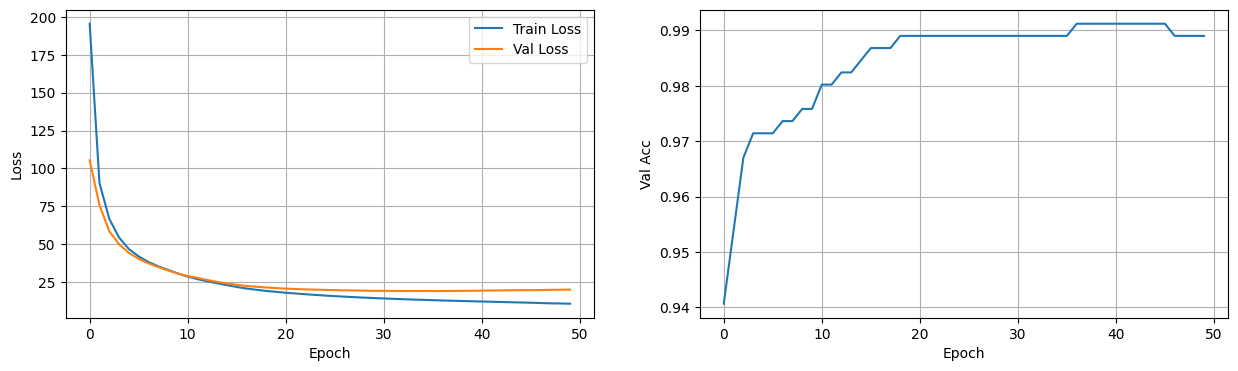

In [129]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('breast_cancer.csv') as f:
    # 跳過 first row (標籤名稱)
    data = f.readlines()[1:]

# 濾除第一個 column (Id)
data = [line.strip().split(',')[1:] for line in data]

data = np.array(data)
labels = []

# 第二個 column 為 label
classes = np.unique(data[:, 0])

# 將 label 做 one-hot encoding
for d in data:
    for cls in classes:
        if d[0] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

# 將 input features 與 labels 從原始資料中分離
inputs = data[:, 1:].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化 (沒有做loss會直接 nan)
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
Y_data = labels[idx]

# 設定 train set 和 val set 的比例 (80% train, 20% val)
train_size = int(len(X_data) * 0.8)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)

# batch size 要設為 train_size 的因數才能整除
batch_size = 5
lr = 0.05

# input features 有 30 個，總共兩個 classes
init_params = {
    'w': [
        np.random.randn(30, 10) * np.sqrt(2/4),
        np.random.randn(10, 5) * np.sqrt(2/10),
        # np.random.randn(5, 5) * np.sqrt(2/10),
        np.random.randn(5, 2) * np.sqrt(2/5)
        ],
    'b': [
        np.zeros((1, 10)),
        np.zeros((1, 5)),
        # np.zeros((1, 5)),
        np.zeros((1, 2))
        ],
    'act_func': [
        ReLU,
        ReLU, 
        # ReLU,
        Softmax
                 ]
    }

params = train(init_params, X_train, Y_train, X_val, Y_val, lr, 50, batch_size)
# params

## ========== wine ==========

(1295, 11)
classes: ['3' '4' '5' '6' '7' '8']


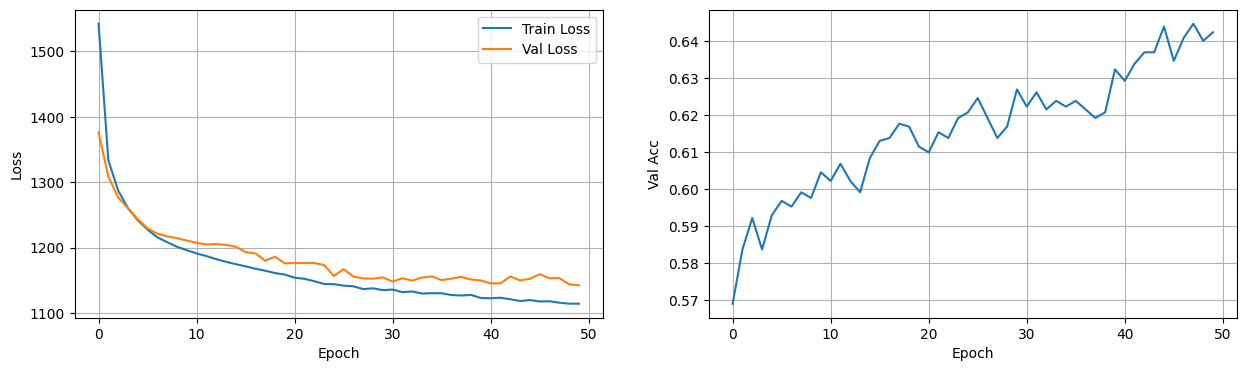

In [138]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('winequality-red.csv') as f:
    # 跳過 first row (標籤名稱)
    data = f.readlines()[1:]

data = [line.strip().split(',') for line in data]

data = np.array(data)
labels = []

# 最後一個 column 為 label
classes = np.unique(data[:, -1])

# 將 label 做 one-hot encoding
for d in data:
    for cls in classes:
        if d[-1] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

# 將 input features 與 labels 從原始資料中分離
inputs = data[:, :-1].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化 (沒有做loss會直接 nan)
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
Y_data = labels[idx]

# 設定 train set 和 val set 的比例 (81% train, 19% val)
train_size = int(len(X_data) * 0.81)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)
print('classes:', classes)

# batch size 要設為 train_size 的因數才能整除
batch_size = 5
lr = 0.05

# input features 有 11 個，總共 6 個 classes
init_params = {
    'w': [
        np.random.randn(11, 10) * np.sqrt(2/4),
        np.random.randn(10, 5) * np.sqrt(2/10),
        # np.random.randn(5, 5) * np.sqrt(2/10),
        np.random.randn(5, 6) * np.sqrt(2/5)
        ],
    'b': [
        np.zeros((1, 10)),
        np.zeros((1, 5)),
        # np.zeros((1, 5)),
        np.zeros((1, 6))
        ],
    'act_func': [
        ReLU,
        ReLU, 
        # ReLU,
        Softmax
                 ]
    }

params = train(init_params, X_train, Y_train, X_val, Y_val, lr, 50, batch_size)
# params